# (unsorted) Rotating MNIST
Diagonal online Laplace with a replay buffer v.s. diagonal LoFi

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
kmode = "valid"
ksize = 200
kernel = np.ones(ksize) / ksize

## Hyperparameter optimisation

In [ ]:
%%time
%run rotating_mnist_unsorted.py

Training RSGD adam
|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -1.865e+0 | -11.38    |
| 2         | -3.89e+04 | -9.025    |
| 3         | -4.38e+04 | -7.787    |
| 4         | -8.039e+0 | -14.96    |
| 5         | -7.902e+0 | -14.28    |
| 6         | -8.025e+0 | -14.94    |
| 7         | -2.892e+0 | -10.72    |
| 8         | -2.538e+0 | -10.91    |
| 9         | -4.497e+0 | -7.556    |
| 10        | -4.179e+0 | -7.592    |
| 11        | -7.879e+0 | -14.56    |
| 12        | -8.176e+0 | -13.91    |
| 13        | -8.876e+0 | -13.52    |
| 14        | -7.903e+0 | -14.28    |
| 15        | -8.025e+0 | -14.94    |
| 16        | -7.902e+0 | -14.28    |
| 17        | -1.086e+0 | -13.01    |
| 18        | -1.575e+0 | -12.47    |
| 19        | -1.811e+0 | -11.94    |
| 20        | -4.25e+04 | -6.5      |
| 21        | -4.059e+0 | -9.915    |
| 22        | -9.648e+0 | -13.27    |
| 23        | -1.282e+0 | -12.75    |
| 24        | -8.454e+0 | -13.7

## Building agent

In [6]:
lr = np.exp(optimiser_rsgd.max["params"]["log_lr"])
tx = optax.sgd(lr)

agent_rsgd = rsgd.init_regression_agent(
    key, part_log_likelihood, model, X_train, tx, memory_size,
    lossfn=part_lossfn,
    prior_precision=1 / initial_covariance,
)

In [6]:
lr = np.exp(optimiser_rsgd_adam.max["params"]["log_lr"])
tx = optax.adam(lr)

agent_rsgd_adam = rsgd.init_regression_agent(
    key, part_log_likelihood, model, X_train, tx, memory_size,
    lossfn=part_lossfn,
    prior_precision=1 / initial_covariance,
)

In [20]:
dynamics_covariance = np.exp(optimiser_lofi.max["params"]["log_dynamics_covariance"])
dynamics_weights = 1 - np.exp(optimiser_lofi.max["params"]["log_1m_dynamics_weights"])

agent_lofi, rfn = lofi.init_regression_agent(
    key, model, X_train,
    initial_covariance, dynamics_weights, dynamics_covariance,
    emission_cov, memory_size
)

## Run agents

In [21]:
callback = partial(callbacks.cb_reg_mc,
                ymean=ymean, ystd=ystd,
                X_test=X_test, y_test=Y_test,
                key=key,
)

In [8]:
callback_rsgd = partial(callback, apply_fn=agent_rsgd.apply_fn, agent=agent_rsgd)
bel_rsgd, output_rsgd = agent_rsgd.scan(X_train, Y_train, progress_bar=True, callback=callback_rsgd)
output_rsgd = tree_to_cpu(output_rsgd)

  0%|          | 0/5458 [00:00<?, ?it/s]

In [22]:
callback_lofi = partial(callback, apply_fn=agent_lofi.params.emission_mean_function, agent=agent_lofi)
bel_lofi, output_lofi = agent_lofi.scan(X_train, Y_train, progress_bar=True, callback=callback_lofi)
output_lofi = tree_to_cpu(output_lofi)

  0%|          | 0/5458 [00:00<?, ?it/s]

## Plot results

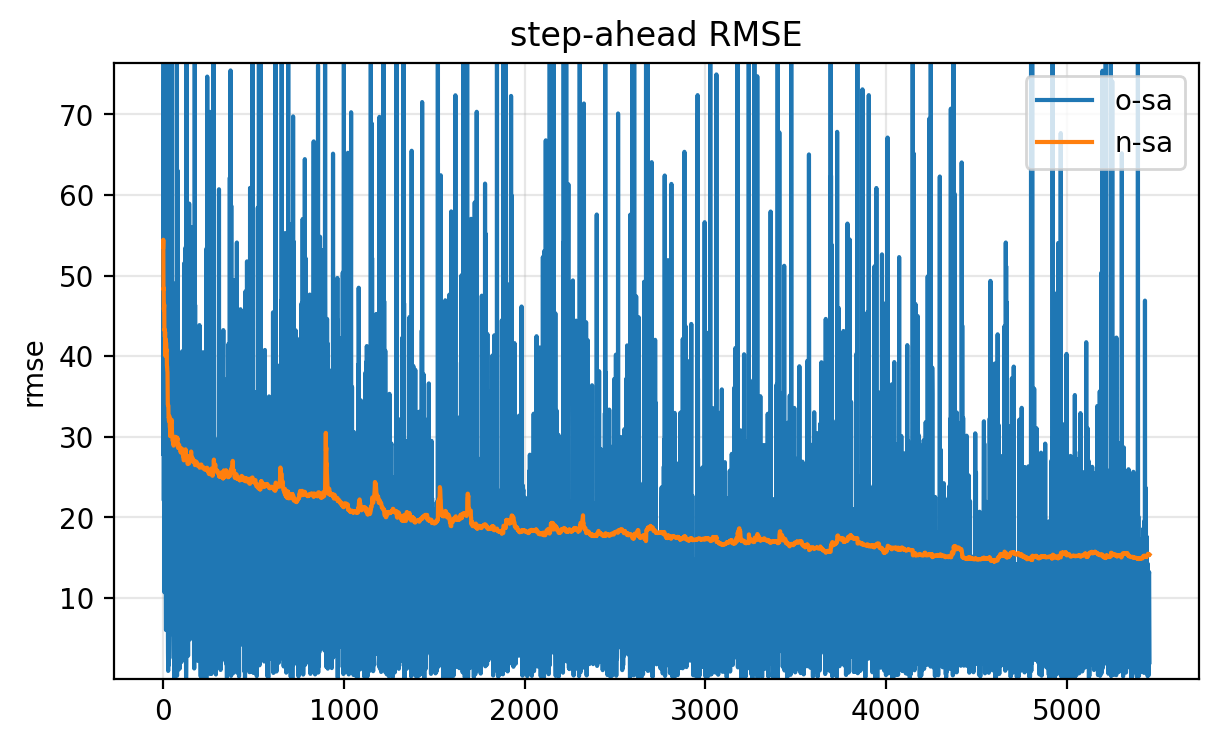

In [23]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_osa = output_lofi["osa-metric"]
err_smooth_nsa = output_lofi["test-metric"]

plt.plot(err_smooth_osa, label="o-sa")
plt.plot(err_smooth_nsa, label="n-sa")

plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth_osa, 0.00)
vmax = np.quantile(err_smooth_osa, 0.99)
plt.ylabel("rmse")
plt.legend()
plt.title("step-ahead RMSE")
plt.ylim(vmin, vmax);

Text(0.5, 1.0, 'step-ahead RMSE (smooth k200)')

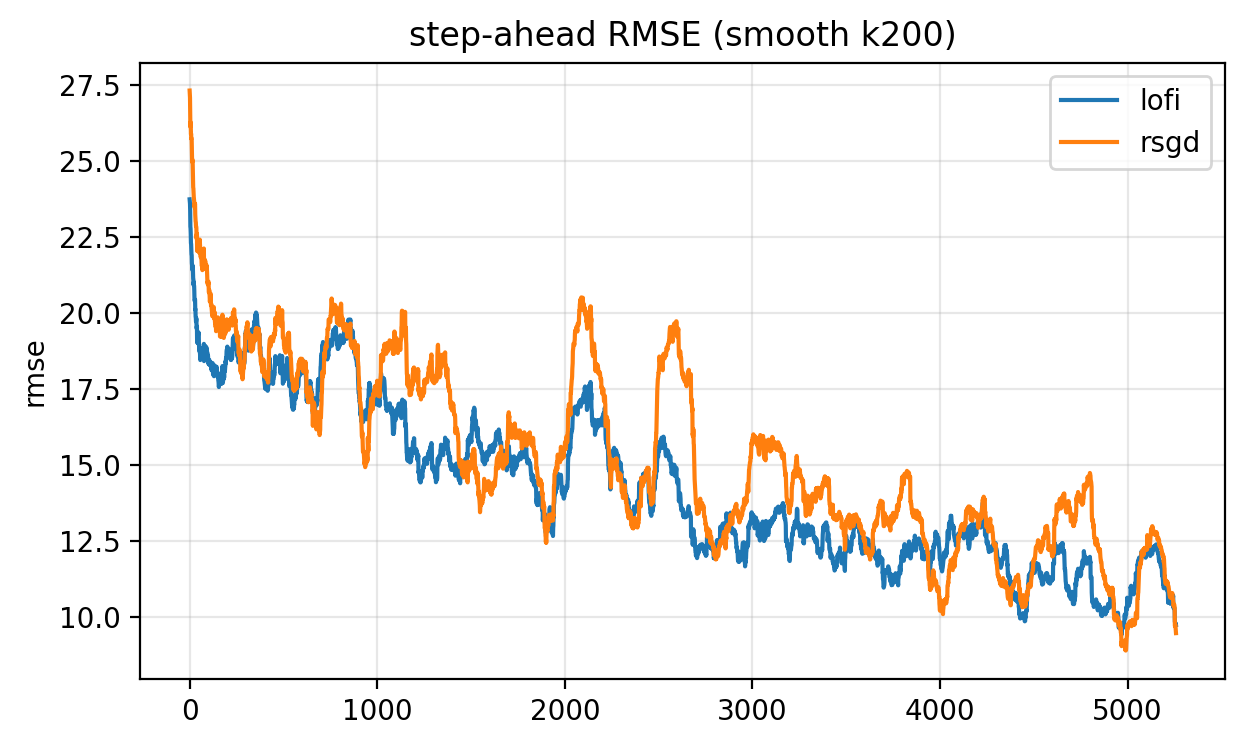

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_lofi = output_lofi["osa-metric"]
err_smooth_rsgd = output_rsgd["osa-metric"]

err_smooth_lofi = np.convolve(err_smooth_lofi, kernel, mode=kmode)
err_smooth_rsgd = np.convolve(err_smooth_rsgd, kernel, mode=kmode)

plt.plot(err_smooth_lofi, label="lofi")
plt.plot(err_smooth_rsgd, label="rsgd")

plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth_osa, 0.00)
vmax = np.quantile(err_smooth_osa, 0.99)
plt.ylabel("rmse")
plt.legend()
plt.title(f"step-ahead RMSE (smooth k{ksize})")
# plt.ylim(vmin, vmax);

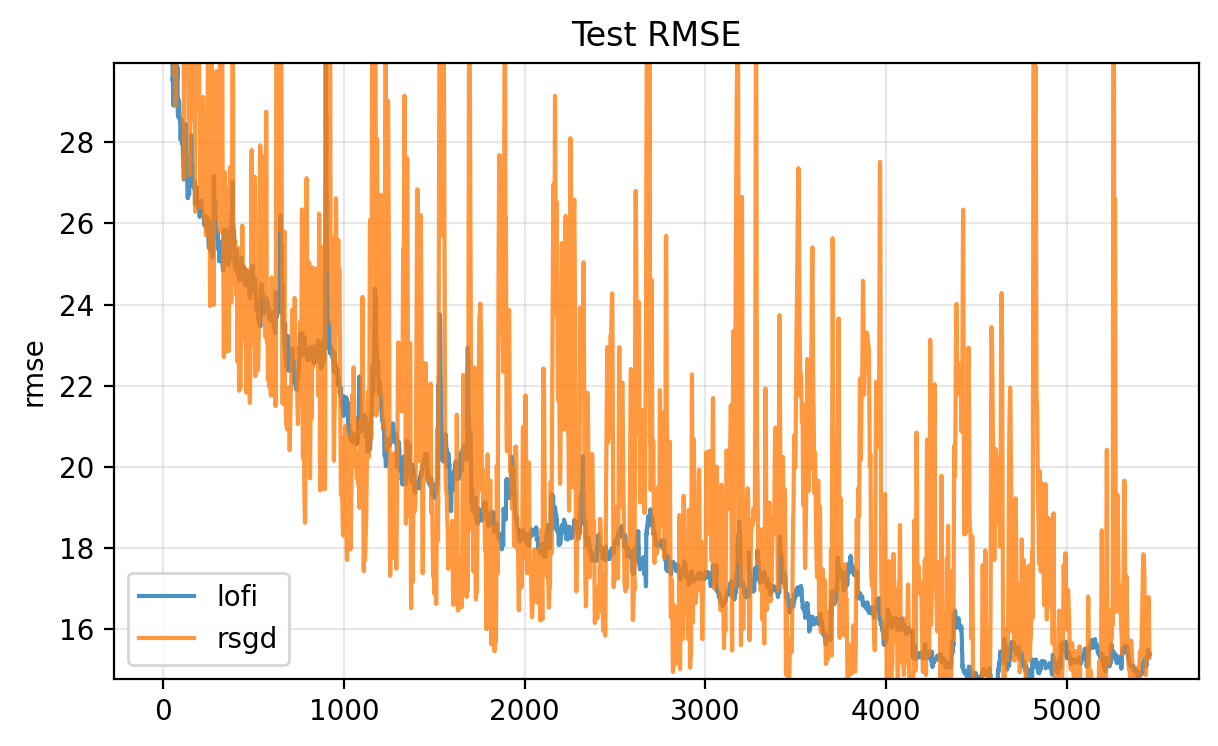

In [32]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_lofi = output_lofi["test-metric"]
err_smooth_rsgd = output_rsgd["test-metric"]

plt.plot(err_smooth_lofi, label="lofi", alpha=0.8)
plt.plot(err_smooth_rsgd, label="rsgd", alpha=0.8)

plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth_lofi, 0.01)
vmax = np.quantile(err_smooth_lofi, 0.99)
plt.ylabel("rmse")
plt.legend()
plt.title("Test RMSE")
plt.ylim(vmin, vmax);

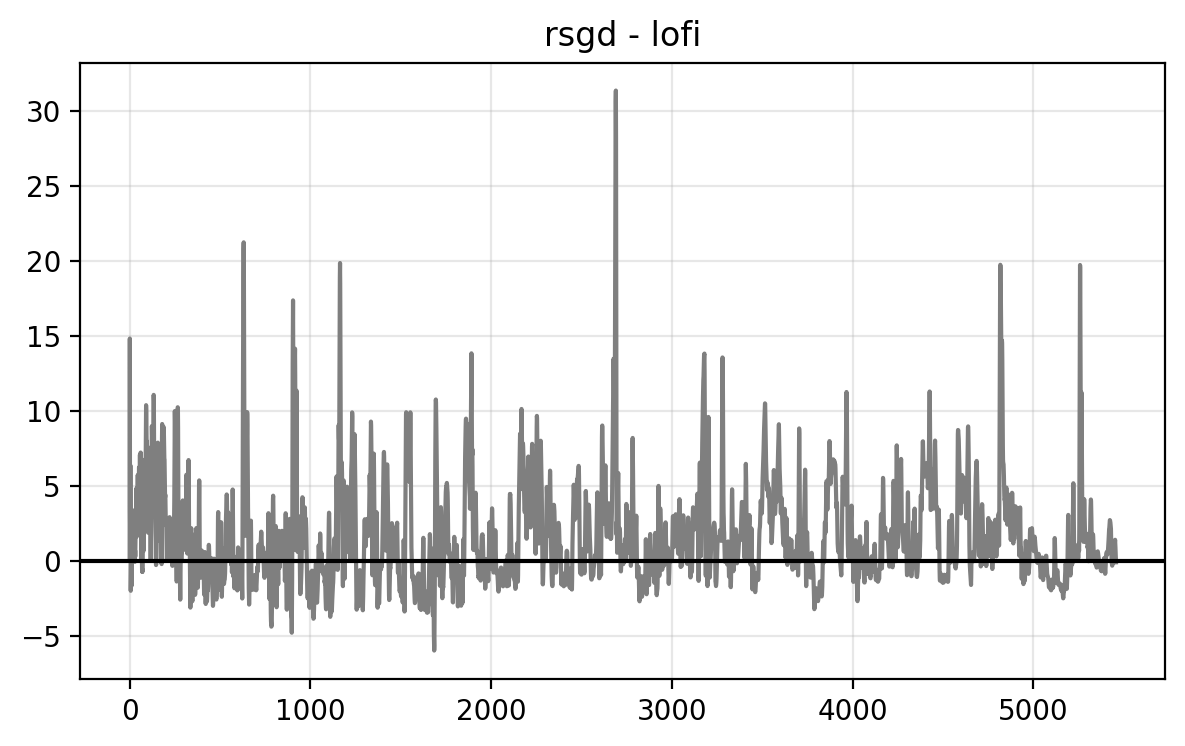

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(err_smooth_rsgd - err_smooth_lofi, c="tab:gray")
plt.axhline(y=0, c="black")
plt.title("rsgd - lofi")
plt.grid(alpha=0.3)

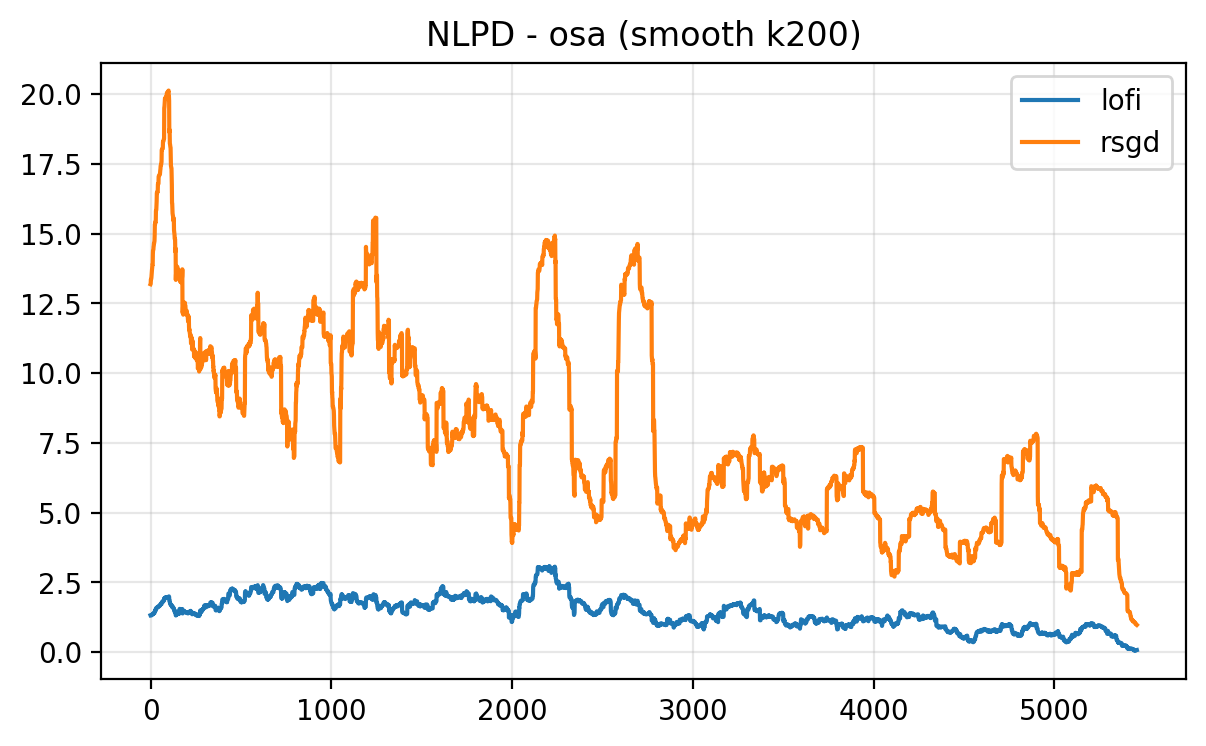

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

metric_lofi = output_lofi["nlpd"]
metric_rsgd = output_rsgd["nlpd"]

metric_lofi = np.convolve(metric_lofi, kernel, mode="same")
metric_rsgd = np.convolve(metric_rsgd, kernel, mode="same")

plt.plot(metric_lofi, label="lofi")
plt.plot(metric_rsgd, label="rsgd")

plt.title(f"NLPD - osa (smooth k{ksize})")
plt.legend()
plt.grid(alpha=0.3)

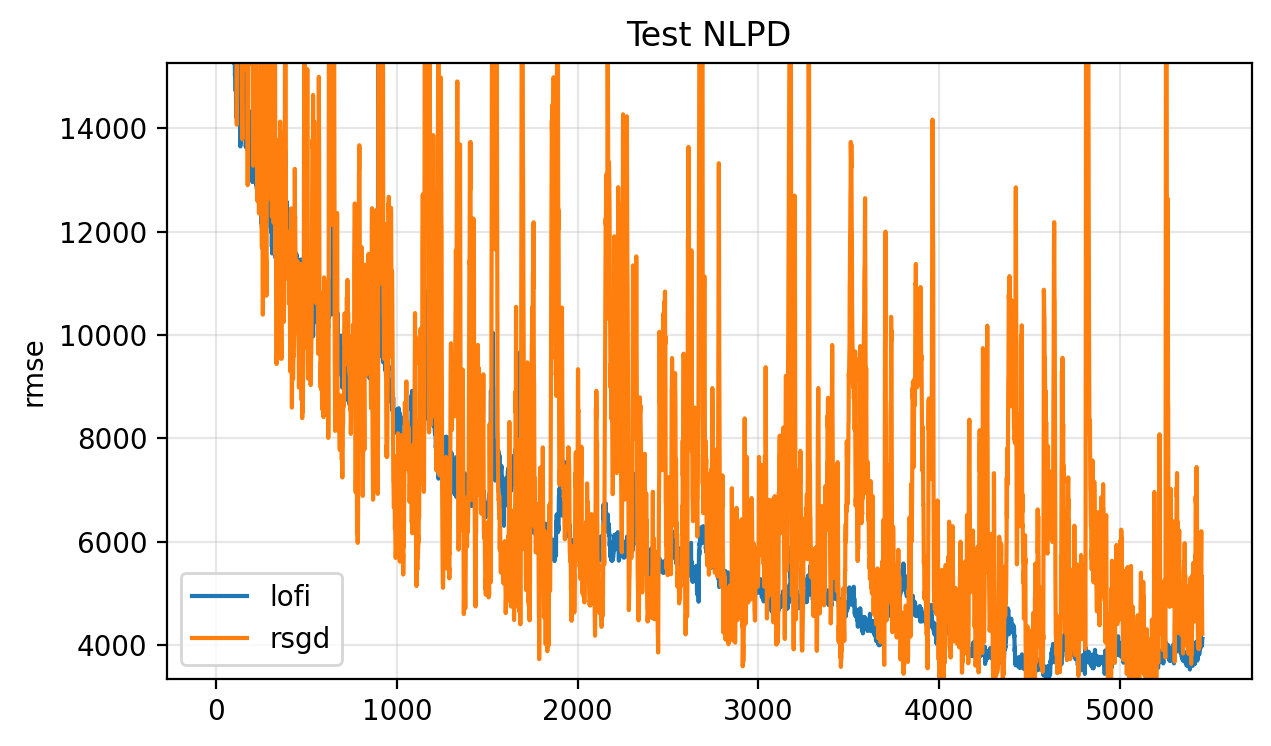

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_lofi = output_lofi["nlpd_test"]
err_smooth_rsgd = output_rsgd["nlpd_test"]

plt.plot(err_smooth_lofi, label="lofi")
plt.plot(err_smooth_rsgd, label="rsgd")

plt.grid(alpha=0.3)

plt.legend()
plt.title("Test NLPD")

vmin = np.quantile(err_smooth_lofi, 0.00)
vmax = np.quantile(err_smooth_lofi, 0.98)
plt.ylim(vmin, vmax);

In [22]:
ytest = Y_test * ystd + ymean
yhattest_lofi = agent_lofi.params.emission_mean_function(bel_lofi.mean, X_test).ravel() * ystd + ymean
yhattest_rsgd = agent_rsgd.apply_fn(bel_rsgd.mean, X_test).ravel() * ystd + ymean

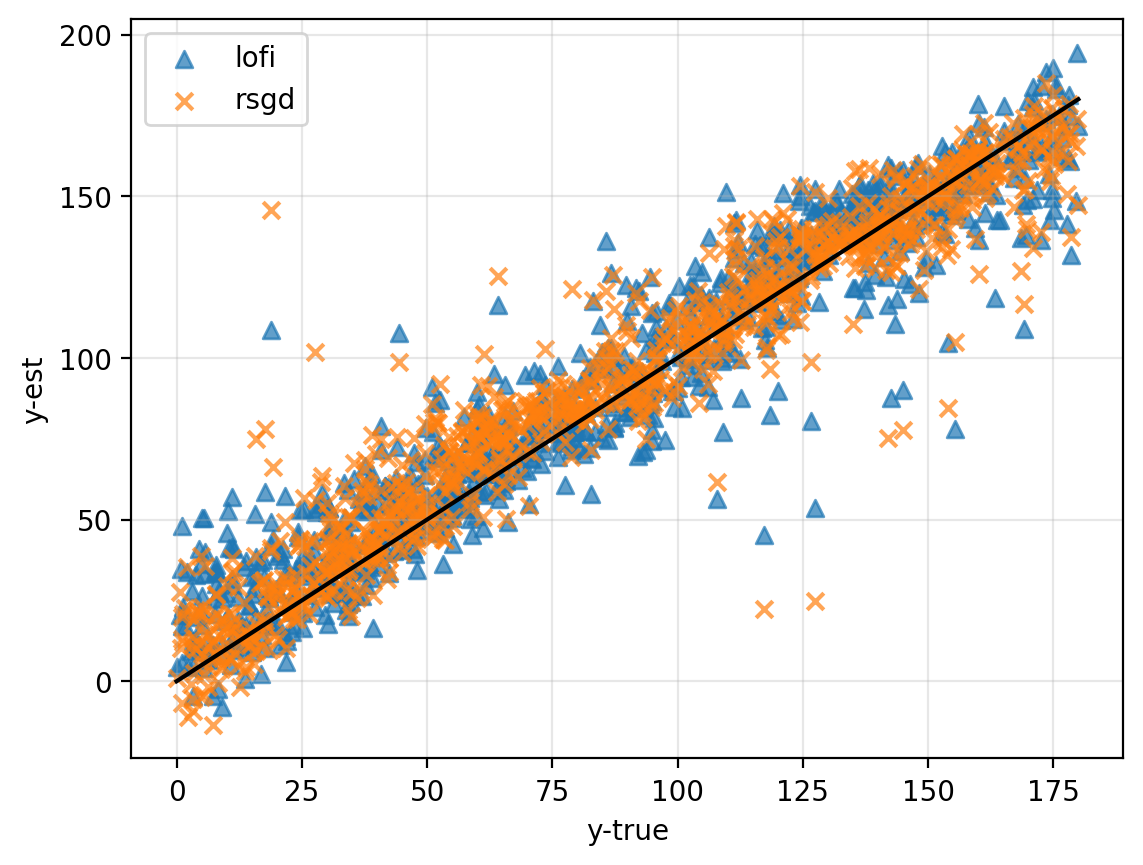

In [23]:
plt.scatter(ytest, yhattest_lofi, label="lofi", alpha=0.7, marker="^")
plt.scatter(ytest, yhattest_rsgd, label="rsgd", alpha=0.7, marker="x")
plt.xlabel("y-true")
plt.ylabel("y-est")
plt.legend()
plt.plot([0,180], [0, 180], c="black")
plt.grid(alpha=0.3)